In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [2]:
df = pd.read_csv('energydata_complete.csv',index_col='date',
                 infer_datetime_format=True)

In [3]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

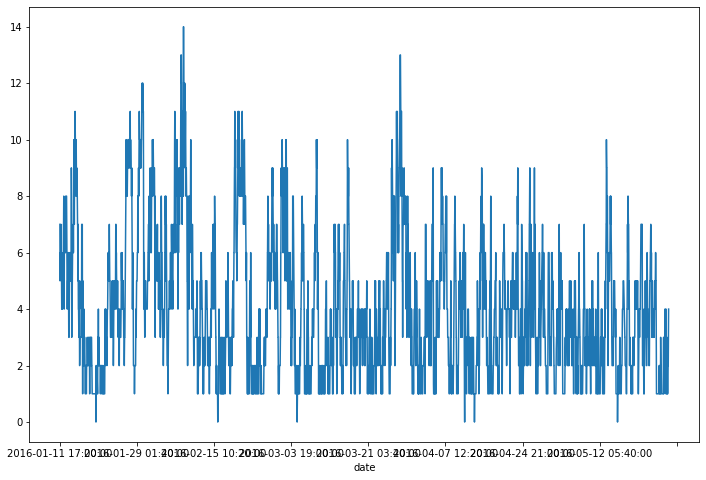

In [5]:
df['Windspeed'].plot(figsize=(12,8))

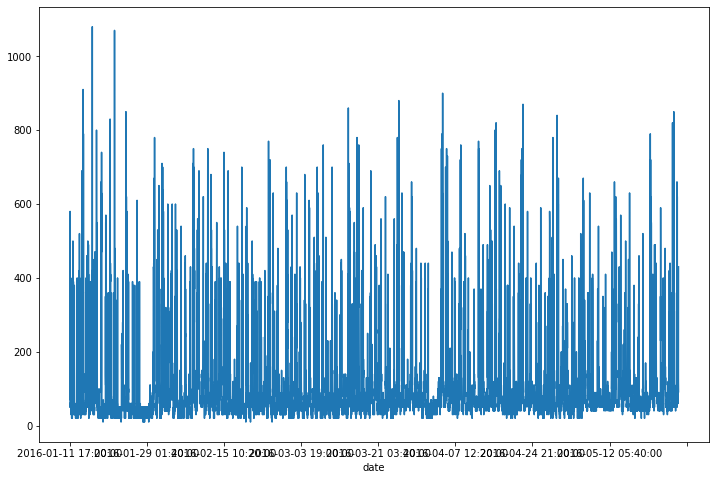

In [6]:
df['Appliances'].plot(figsize=(12,8))

## Train and Test Split

In [7]:
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [8]:
df_mounth = df.loc['2016-05-01':] # last mounth of the df
df_mounth = df_mounth.round(2)

In [9]:
test_days = 2
test_index = test_days * int(24*60/10)
train = df_mounth.iloc[:-test_index]
test = df_mounth.iloc[-test_index:]

In [10]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [15]:
length = 144
batch_size = 1
generator = TimeseriesGenerator(train_scaled,train_scaled,
                                length=length,batch_size=batch_size)

In [28]:
model = Sequential()

model.add(LSTM(25,input_shape=(length,train_scaled.shape[1])))

model.add(Dense(train_scaled.shape[1]))

model.compile(optimizer='adam',loss='mse')

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25)                5400      
_________________________________________________________________
dense (Dense)                (None, 28)                728       
Total params: 6,128
Trainable params: 6,128
Non-trainable params: 0
_________________________________________________________________


In [31]:
early_stop = EarlyStopping(monitor='val_loss',patience=1)
generator_valid = TimeseriesGenerator(test_scaled,test_scaled,
                                     length=length,batch_size=batch_size)

In [32]:
model.fit_generator(generator,epochs=3,
                    validation_data=generator_valid,
                    callbacks=[early_stop])

Epoch 1/3
3421/3421 [==============================] - 1225s 358ms/step - loss: 0.0165 - val_loss: 0.0130
Epoch 2/3
3421/3421 [==============================] - 1051s 307ms/step - loss: 0.0090 - val_loss: 0.0109
Epoch 3/3
3421/3421 [==============================] - 1189s 347ms/step - loss: 0.0081 - val_loss: 0.0094


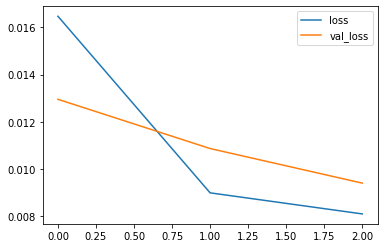

In [33]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test

In [34]:
first_eval_batch = train_scaled[-length:]
first_eval_batch = first_eval_batch.reshape(1,length,train_scaled.shape[1])
model.predict(first_eval_batch)

array([[0.08414789, 0.00464583, 0.67042345, 0.40681037, 0.5429299 ,
        0.43938524, 0.40086177, 0.451806  , 0.68166834, 0.3625406 ,
        0.2892124 , 0.35237336, 0.6401956 , 0.03892915, 0.64309907,
        0.36160007, 0.5307356 , 0.32046267, 0.5722887 , 0.3308447 ,
        0.6278031 , 0.5308491 , 0.41479415, 0.20918435, 0.53782105,
        0.50279194, 0.49287674, 0.54787135]], dtype=float32)

In [36]:
test_scaled[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

In [37]:
n_features = train_scaled.shape[1]
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)

In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

In [41]:
true_predictions = pd.DataFrame(true_predictions,columns=test.columns)
true_predictions.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,84.793872,0.139375,24.325386,38.268307,24.160336,35.236525,24.962153,37.318170,23.971678,36.710395,...,22.190359,37.026022,17.018395,756.203359,55.524355,2.091843,37.269263,7.097184,24.639051,27.387131
1,80.675249,0.256979,24.300881,38.023026,23.882500,35.219046,24.904828,37.117351,23.892079,36.566827,...,22.252849,36.950231,16.783456,756.407877,56.313224,2.001538,36.127715,6.907758,24.937105,27.412907
2,76.095444,0.417854,24.265001,37.818557,23.681947,35.297811,24.841949,36.910929,23.858575,36.410499,...,22.292181,36.923282,16.518028,756.472252,56.830313,1.926748,35.102639,6.779248,24.967268,27.430256
3,71.306309,0.604997,24.222510,37.621619,23.484838,35.390265,24.776822,36.745234,23.836282,36.251909,...,22.322369,36.918561,16.240196,756.493608,57.352268,1.855258,34.158237,6.659196,24.993572,27.457170
4,66.445294,0.789931,24.175762,37.431423,23.287715,35.493749,24.710785,36.601755,23.818131,36.092191,...,22.346256,36.928067,15.945397,756.496804,57.878798,1.781338,33.255754,6.539563,25.011051,27.480687


In [46]:
test.describe()['Appliances']

count    288.000000
mean     137.847222
std      139.239664
min       40.000000
25%       60.000000
50%       75.000000
75%      162.500000
max      850.000000
Name: Appliances, dtype: float64

In [45]:
(mean_squared_error(true_predictions['Appliances'],test['Appliances']))**0.5

178.7086873760524